# Satellite Data Preprocessing Pipeline
# Author: Iman Mahato
# Project: Groundwater Vulnerability Mapping

# Overview
This workflow processes and harmonizes two different(GRACE JPL & GLDAS Noah) hydrological datasets to create a single spatiotemporal data for Deep Learning analysis.

# Key Operations in this part:
1.  Unit Conversion: Converting all GLDAS variables (like Soil Moisture (kg/m^2)) to Water Height (cm).
2.  Spatial Alignment: Clipping global datasets to the West Bengal study area.
3.  Resolution Matching: Resampling different pixel sizes (e.g., coarse GRACE vs. fine GLDAS) so they all fit on the same 0.5° resolution.
4.  Anomaly Calculation: Converting absolute values (like total soil moisture) into anomalies (deviation from the long-term average) to align with GRACE data structure.
5.  Gap Filling: Creating a continuous timeline by handling missing months in the satellite record.

In [29]:

import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import xarray as xr
import numpy as np
from datetime import datetime

In [ ]:
#Ratio to convert GLDAS data from kg/m^2 to cm
KG_M2_TO_CM_RATIO = 0.1   ## Conversion factor: 1 kg/m^2 water = 1 mm = 0.1 cm depth

BASE_DIR = r'F:\New Begining Project\Data\RAW'

# Default figure size for plots
FIG_SIZE = (10, 10)

In [51]:
# Common functions
def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

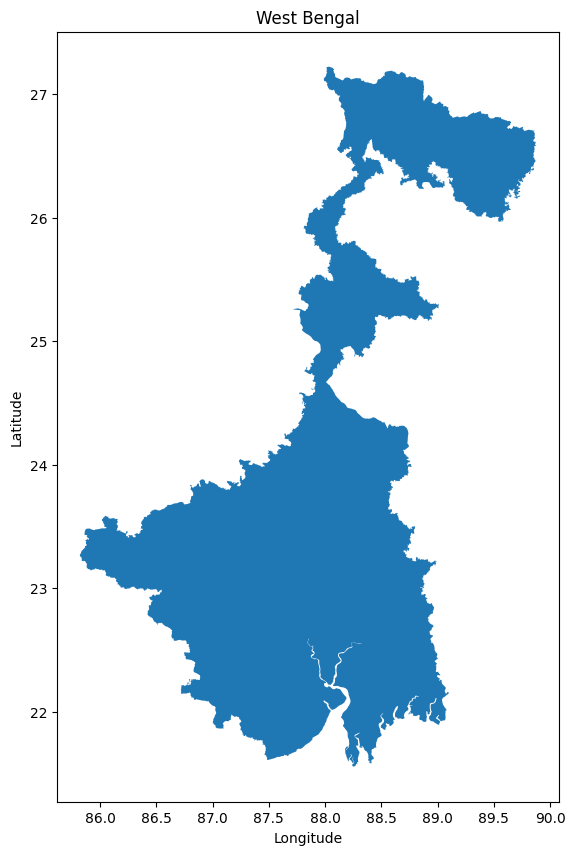

In [52]:
# Read the shapefile
basin_shapefile = gpd.read_file(r'F:\New Begining Project\Data\RAW\shapefiles\West Bengal\West_Bengal.shp')

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


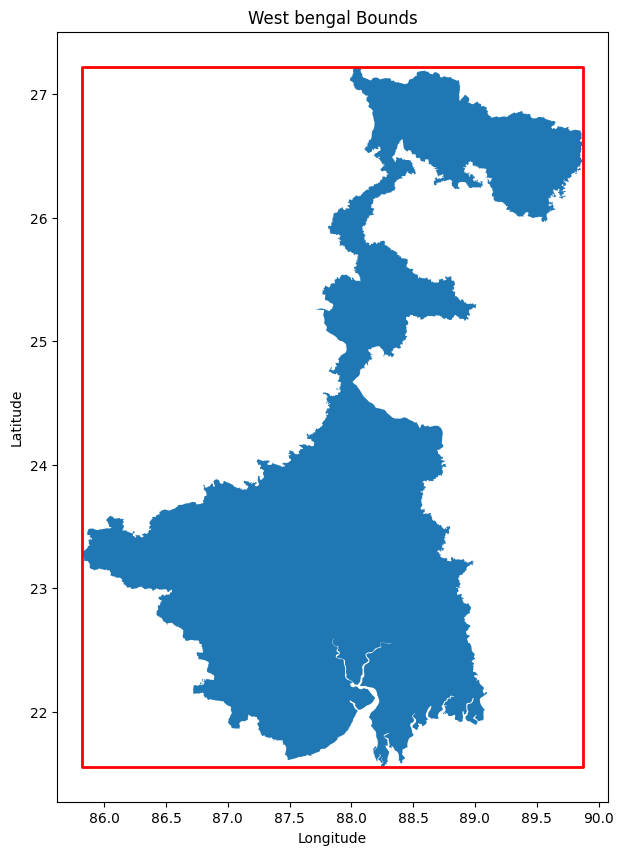

In [53]:
# Extracting the exact spatial bounds of the study area (West Bengal)

[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Visualize the bounding box

bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])

# Plotting both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [54]:
# Loading the GRACE data to see the details.
grace = xr.open_dataset(r"F:\New Begining Project\Data\RAW\GRACE\GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc")

grace

<xarray.Dataset> Size: 2GB
Dimensions:        (lon: 720, lat: 360, time: 247, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-07-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 512MB ...
    uncertainty    (time, lat, lon) float64 512MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 512MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.3Mv04 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2025-09-15T07:09:14Z

In [ ]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray
import os 

# Defining the data
BASE_DIR = r'F:\New Begining Project\Data\RAW'
RAW_GRACE_FILE = os.path.join(BASE_DIR, 'GRACE', 'GRCTellus.JPL.200204_202507.GLO.RL06.3M.MSCNv04CRI.nc')
SHAPEFILE = os.path.join(BASE_DIR, 'shapefiles', 'West Bengal', 'West_Bengal.shp')
OUTPUT_CSV = r'F:\New Begining Project\Data\Processed\TWS_GRACE_JPL_WestBengal_cm.csv'


# 1. Load the raw GRACE file and the West Benagl shapefile
print("Loading raw GRACE data and shapefile...")
grace = xr.open_dataset(RAW_GRACE_FILE)
basin_shapefile = gpd.read_file(SHAPEFILE)
basin_shapefile = basin_shapefile.to_crs('epsg:4326')


# 2. Create the 'tws_scaled' variable by multiplying the scale factor.
print("Applying scale factor (lwe_thickness * scale_factor)...")
grace['tws_scaled'] = grace['lwe_thickness'] * grace['scale_factor']


# 3. Select variables and Clip the GRACE data 
variables_to_keep = ['tws_scaled', 'uncertainty']
grace_to_clip = grace[variables_to_keep]

print("Clipping GRACE data to the West Benagl boundary...")
grace_to_clip = grace_to_clip.rio.set_spatial_dims(x_dim="lon", y_dim="lat").rio.write_crs("epsg:4326")
grace_clipped = grace_to_clip.rio.clip(basin_shapefile.geometry, basin_shapefile.crs, all_touched=True, drop=True)
print("Clipping complete.")

# 4. Convert to DataFrame and Clean Up 
grace_df = grace_clipped.to_dataframe().reset_index()

# Standardize all timestamps to the first of the month
print("Standardizing timestamps to the 1st of each month...")
grace_df['time'] = pd.to_datetime(grace_df['time']).dt.to_period('M').dt.start_time

grace_df = grace_df.rename(columns={'tws_scaled': 'tws_scaled_cm', 'uncertainty': 'uncertainty_cm'})
grace_df.sort_values(by=['time', 'lat', 'lon'], inplace=True)

# 5. Save the final corrected file
grace_df.to_csv(OUTPUT_CSV, index=False)

print(f"\nSUCCESS: A new, correct version of '{OUTPUT_CSV}' has been created with standardized dates.")
print(grace_df.head())

Loading raw GRACE data and shapefile...
Applying scale factor (lwe_thickness * scale_factor)...
Clipping GRACE data to the West Benagl boundary...
Clipping complete.
Standardizing timestamps to the 1st of each month...

SUCCESS: A new, correct version of 'F:\New Begining Project\Data\Processed\TWS_GRACE_JPL_WestBengal_cm.csv' has been created with standardized dates.
         lon    lat       time  spatial_ref  WGS84  tws_scaled_cm  \
0      85.75  21.75 2002-04-01            0      0            NaN   
2964   86.25  21.75 2002-04-01            0      0            NaN   
5928   86.75  21.75 2002-04-01            0      0            NaN   
8892   87.25  21.75 2002-04-01            0      0      -6.268142   
11856  87.75  21.75 2002-04-01            0      0      -6.268142   

       uncertainty_cm  
0                 NaN  
2964              NaN  
5928              NaN  
8892        18.358783  
11856       18.358783  


In [56]:
# Reading one file of the GLDAS data

xr.open_dataset(r"F:\New Begining Project\Data\RAW\GLDAS\GLDAS_NOAH025_M_2.1-20250814_151559\GLDAS_NOAH025_M.A200001.021.nc4")

<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst           (time, lat, lon) float32 3MB ...
    SWdown_f_tavg          (time, lat, lon) float32 3MB ...
    LWdown_f_tavg          (time, lat, lon) float32 3MB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [57]:
import pandas as pd
import xarray as xr
import os

# Define the path to GLDAS files
gldas_path = r"F:\New Begining Project\Data\RAW\GLDAS\GLDAS_NOAH025_M_2.1-20250814_151559"

# Create an empty DataFrame to store the combined data
gldas_df = pd.DataFrame()

# Define the list of soil moisture layers to sum
soil_layers = [
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilMoi40_100cm_inst', 
    'SoilMoi100_200cm_inst'
]

print("Starting memory-efficient GLDAS data processing...")
# Iterate through each file in the directory
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        file_path = os.path.join(gldas_path, filename)
        
        # 1. Reading data as xarray
        xd = xr.open_dataset(file_path)

        # 2. Filter the xarray object FIRST 
        xd_subset = xd.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

        # 3. Convert only the SMALL SUBSET to a DataFrame
        xd_df = xd_subset.to_dataframe()
        xd_df.reset_index(inplace=True)

        # 4. Perform the calculations on the small DataFrame
        xd_df['SoilMoi0_200cm_inst'] = xd_df[soil_layers].sum(axis=1)

        # Extract only the columns we need
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "Qs_acc", "SoilMoi0_200cm_inst"]]
        df_slice = df_slice.drop_duplicates()

        # Append the data for this month to the main DataFrame
        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

# Rename the columns to include units for clarity
gldas_df = gldas_df.rename(columns={
    'SWE_inst': 'SWE_inst_kg/m2',
    'Qs_acc': 'Qs_acc_kg/m2',
    'SoilMoi0_200cm_inst': 'TotalSoilMoisture_kg/m2'
})

print("\nGLDAS data processing complete.")
print("\nPreview of the Final GLDAS Data")
print(gldas_df.head())

Starting memory-efficient GLDAS data processing...

GLDAS data processing complete.

Preview of the Final GLDAS Data
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  
0               402.055817  
1               411.130768  
2               415.805115  
3               629.142212  
4               634.998657  


In [58]:
# Step 1: Define the conversion ratio
# Kilograms per square meter to Centimeters
KG_M2_TO_CM_RATIO = 0.1 

# Step 2: Convert Units from kg/m^2 to cm
print("Converting all GLDAS variables to depth (cm)...")

# Apply the conversion to the Total Soil Moisture column
gldas_df['TotalSoilMoisture_cm'] = gldas_df['TotalSoilMoisture_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to the Snow Water Equivalent column
gldas_df['SWE_cm'] = gldas_df['SWE_inst_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to the Runoff column
gldas_df['Qs_acc_cm'] = gldas_df['Qs_acc_kg/m2'] * KG_M2_TO_CM_RATIO

print("\nUnit conversion to cm complete.")
print("\nPreview of Data with Centimeter Columns")

print(gldas_df.head())

Converting all GLDAS variables to depth (cm)...

Unit conversion to cm complete.

Preview of Data with Centimeter Columns
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  21.625             0.0      0.000005   
1 2000-01-01  85.875  21.875             0.0      0.000012   
2 2000-01-01  85.875  22.125             0.0      0.000021   
3 2000-01-01  85.875  22.375             0.0      0.000177   
4 2000-01-01  85.875  22.625             0.0      0.000230   

   TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm     Qs_acc_cm  
0               402.055817             40.205582     0.0  4.717742e-07  
1               411.130768             41.113079     0.0  1.153226e-06  
2               415.805115             41.580513     0.0  2.112903e-06  
3               629.142212             62.914223     0.0  1.770161e-05  
4               634.998657             63.499866     0.0  2.297581e-05  


In [59]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import os

print("Starting precise clip for GLDAS data (Polygon Method)...")

# Step 0: Define Grid Resolution
# For GLDAS NOAH, the grid size is 0.25 degrees.
GRID_SIZE = 0.25
HALF_SIZE = GRID_SIZE / 2.0

# Step 1: Optimize - Work on Unique Pixels Only
# Creating polygons for millions of time-steps is slow. We only need to figure out which *locations* (lat/lon) are valid.
unique_pixels = gldas_df[['lat', 'lon']].drop_duplicates()

print(f"Identifying valid pixels from {len(unique_pixels)} unique locations...")

# Step 2: Create Square Polygons
# Instead of points, we make boxes: (lon-half, lat-half) to (lon+half, lat+half)
geometries = [
    box(lon - HALF_SIZE, lat - HALF_SIZE, lon + HALF_SIZE, lat + HALF_SIZE)
    for lon, lat in zip(unique_pixels['lon'], unique_pixels['lat'])
]

unique_gdf = gpd.GeoDataFrame(unique_pixels, geometry=geometries, crs='epsg:4326')

# Step 3: Perform the Spatial Join
# predicate="intersects" checks if the BOX overlaps the SHAPEFILE at all.
valid_pixels_gdf = gpd.sjoin(unique_gdf, basin_shapefile, how="inner", predicate="intersects")

# Get the list of valid lat/lon pairs
valid_pixels = valid_pixels_gdf[['lat', 'lon']].drop_duplicates()

print(f"Found {len(valid_pixels)} pixels that touch or overlap the shapefile.")

# Step 4: Filter the Original Data
# Now we simply keep the rows in your main dataframe that match these valid locations
gldas_final_df = gldas_df.merge(valid_pixels, on=['lat', 'lon'], how='inner')

print("\nGLDAS data successfully clipped (including border pixels).")
print(f"Total rows remaining: {len(gldas_final_df)}")
print(gldas_final_df.head())

Starting precise clip for GLDAS data (Polygon Method)...
Identifying valid pixels from 368 unique locations...
Found 179 pixels that touch or overlap the shapefile.

GLDAS data successfully clipped (including border pixels).
Total rows remaining: 54416
        time     lon     lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  85.875  23.125             0.0      0.000044   
1 2000-01-01  85.875  23.375             0.0      0.000048   
2 2000-01-01  86.125  22.875             0.0      0.000405   
3 2000-01-01  86.125  23.125             0.0      0.000061   
4 2000-01-01  86.125  23.375             0.0      0.000035   

   TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  
0               424.652496             42.465252     0.0   0.000004  
1               450.469360             45.046936     0.0   0.000005  
2               674.233398             67.423340     0.0   0.000040  
3               458.309387             45.830940     0.0   0.000006  
4               419.4611

In [60]:
# Define a name for the output file
output_filename = r'F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_high_resolution.csv'

# Save the gldas_final_df DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
gldas_final_df.to_csv(output_filename, index=False)

print(f"Successfully saved the clipped high-resolution GLDAS data to '{output_filename}'")

Successfully saved the clipped high-resolution GLDAS data to 'F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_high_resolution.csv'


In [61]:
import pandas as pd
import numpy as np

# Step 1: Load the clipped GLDAS NOAH file
input_filename = r'F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_high_resolution.csv' 
output_filename = r'F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_cleaned.csv'

print(f"Cleaning negative values from: {input_filename}")
try:
    df = pd.read_csv(input_filename)
    print(f"File loaded successfully with {len(df)} rows.")

    # Step 2: Find and replace negative values
    print("\nScanning for and replacing negative values...")
    
    # Get a list of all numeric columns to check
    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        # Check if any negative values exist in the column
        negative_mask = df[col] < 0
        num_negatives = negative_mask.sum()

        if num_negatives > 0:
            print(f"- Found {num_negatives} negative values in column '{col}'. Replacing with NaN.")
            # Use .mask() to replace values where the condition is True (i.e., where value < 0)
            df[col] = df[col].mask(negative_mask, np.nan)
        else:
            print(f"- No negative values found in column '{col}'.")
    
    # Step 3: Save the cleaned DataFrame to a new file
    df.to_csv(output_filename, index=False)
    
    print(f"\nCleaning complete. The cleaned data has been saved to '{output_filename}'")
    
except FileNotFoundError:
    print(f"ERROR: The file '{input_filename}' was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Cleaning negative values from: F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_high_resolution.csv
File loaded successfully with 54416 rows.

Scanning for and replacing negative values...
- No negative values found in column 'lon'.
- No negative values found in column 'lat'.
- No negative values found in column 'SWE_inst_kg/m2'.
- No negative values found in column 'Qs_acc_kg/m2'.
- No negative values found in column 'TotalSoilMoisture_kg/m2'.
- No negative values found in column 'TotalSoilMoisture_cm'.
- No negative values found in column 'SWE_cm'.
- No negative values found in column 'Qs_acc_cm'.

Cleaning complete. The cleaned data has been saved to 'F:\New Begining Project\Data\Interm Data\gldas_NOAH_cm_clipped_cleaned.csv'


In [62]:
import pandas as pd
import numpy as np
import os
import sys

print("Step: Downscaling GLDAS (0.25°) to match JPL (0.5°) using Coordinate Logic")

# 1. Configuration
BASE_DIR = r'F:\New Begining Project\Data\Interm Data'
INPUT_FILE = os.path.join(BASE_DIR, 'gldas_NOAH_cm_clipped_cleaned.csv')
OUTPUT_FILE = os.path.join(BASE_DIR, 'gldas_NOAH_downscaled_0.5.csv')

# 2. Load Data
print("Loading GLDAS data...")
try:
    df = pd.read_csv(INPUT_FILE)
    df['time'] = pd.to_datetime(df['time'])
    print(f"Loaded {len(df)} rows.")
except FileNotFoundError:
    print(f"Error: Could not find {INPUT_FILE}")
    sys.exit()

# 3. Apply the "Parent Pixel" Math
print("Calculating Target (Parent) Coordinates...")

# It forces the 0.25 coordinates into the center of the 0.5 grid cells
df['lat_target'] = np.floor(df['lat'] * 2) / 2 + 0.25
df['lon_target'] = np.floor(df['lon'] * 2) / 2 + 0.25

# 4. Group and Average
print("Grouping by Time and Target Coordinates...")

# Define which columns are data variables
data_cols = [
    'TotalSoilMoisture_cm', 
    'SWE_cm', 
    'Qs_acc_cm',
    'TotalSoilMoisture_kg/m2', 
    'SWE_inst_kg/m2', 
    'Qs_acc_kg/m2'
]

# Ensure only existing columns are used
available_cols = [c for c in data_cols if c in df.columns]

# The aggregation dictionary: Apply 'mean' to all data columns
agg_dict = {col: 'mean' for col in available_cols}

# Perform the GroupBy
df_downscaled = df.groupby(['time', 'lat_target', 'lon_target']).agg(agg_dict).reset_index()

# 5. Clean Up and Save
print("Renaming coordinates and saving...")

# Rename target coords back to standard names to match JPL
df_downscaled = df_downscaled.rename(columns={
    'lat_target': 'lat',
    'lon_target': 'lon'
})

# Save
df_downscaled.to_csv(OUTPUT_FILE, index=False)

print(f"\nSUCCESS! Downscaling complete.")
print(f"Saved to: {OUTPUT_FILE}")
print("\nPreview of Downscaled Data")
print(df_downscaled.head())

Step: Downscaling GLDAS (0.25°) to match JPL (0.5°) using Coordinate Logic
Loading GLDAS data...
Loaded 54416 rows.
Calculating Target (Parent) Coordinates...
Grouping by Time and Target Coordinates...
Renaming coordinates and saving...

SUCCESS! Downscaling complete.
Saved to: F:\New Begining Project\Data\Interm Data\gldas_NOAH_downscaled_0.5.csv

Preview of Downscaled Data
        time    lat    lon  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
0 2000-01-01  21.75  87.25             47.259265     0.0   0.000002   
1 2000-01-01  21.75  87.75             34.200016     0.0   0.000018   
2 2000-01-01  21.75  88.25             17.779878     0.0   0.000034   
3 2000-01-01  21.75  88.75             68.839350     0.0   0.000052   
4 2000-01-01  21.75  89.25             67.520450     0.0   0.000073   

   TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  Qs_acc_kg/m2  
0               472.592627             0.0      0.000024  
1               342.000137             0.0      0.000176  
2               17

In [63]:
import pandas as pd
import numpy as np
import os
import sys

print("Verifying GLDAS Downscaling Integrity")

# 1. Configuration
DOWNSCALED_FILE = r'F:\New Begining Project\Data\Interm Data\gldas_NOAH_downscaled_0.5.csv'

JPL_FILE = r'F:\New Begining Project\Data\Processed\TWS_GRACE_JPL_WestBengal_cm.csv'

# 2. Load Data
try:
    df = pd.read_csv(DOWNSCALED_FILE)
    print(f"Loaded Downscaled GLDAS: {len(df)} rows")
except FileNotFoundError:
    print(f"Error: File not found {DOWNSCALED_FILE}")
    sys.exit()

# CHECK 1: Grid Spacing
# Check the distance between unique latitude values.
# It MUST be 0.5.
unique_lats = np.sort(df['lat'].unique())
lat_diffs = np.diff(unique_lats)
median_spacing = np.median(lat_diffs)

print("\nCHECK 1: Grid Resolution")
print(f"Unique Latitudes: {len(unique_lats)}")
print(f"Detected Spacing: {median_spacing}")

if np.isclose(median_spacing, 0.5):
    print("PASS: Grid is consistently 0.5 degrees.")
else:
    print(f"FAIL: Grid spacing is {median_spacing} (Expected 0.5).")

# CHECK 2: Pixel Centering
# In a 0.5 degree grid, centers usually end in .25 or .75.

center_check = np.unique(df['lat'] % 0.5)

print("\nCHECK 2: Pixel Centering")
print(f"Coordinate Modulo 0.5: {center_check}")

if np.allclose(center_check, 0.25):
    print("PASS: Coordinates are perfectly centered (end in .25 or .75).")
else:
    print("FAIL: Coordinates look shifted (do not end in .25 or .75).")

# CHECK 3: JPL Alignment
# If JPL file exists, check if GLDAS coordinates exist inside JPL coordinates
if os.path.exists(JPL_FILE):
    print("\nCHECK 3: Match against JPL Master Grid")
    jpl_df = pd.read_csv(JPL_FILE)
    
    # Get unique coordinate pairs as a set
    jpl_coords = set(zip(jpl_df['lat'], jpl_df['lon']))
    gldas_coords = set(zip(df['lat'], df['lon']))
    
    # Check intersection
    common_coords = jpl_coords.intersection(gldas_coords)
    
    print(f"JPL Grid Points: {len(jpl_coords)}")
    print(f"GLDAS Grid Points: {len(gldas_coords)}")
    print(f"Matching Points: {len(common_coords)}")
    
    if len(common_coords) == len(gldas_coords):
        print("PASS: Every GLDAS pixel matches a JPL pixel location.")
    elif len(common_coords) > 0:
        print("WARNING: Partial overlap. (This is normal if GLDAS covers a larger area than the clipped JPL data).")
    else:
        print("FAIL: No coordinate overlap found. The grids are misaligned.")
else:
    print("\n(Skipping Check 3: JPL file not found)")

Verifying GLDAS Downscaling Integrity
Loaded Downscaled GLDAS: 17328 rows

CHECK 1: Grid Resolution
Unique Latitudes: 12
Detected Spacing: 0.5
PASS: Grid is consistently 0.5 degrees.

CHECK 2: Pixel Centering
Coordinate Modulo 0.5: [0.25]
PASS: Coordinates are perfectly centered (end in .25 or .75).

CHECK 3: Match against JPL Master Grid
JPL Grid Points: 108
GLDAS Grid Points: 57
Matching Points: 57
PASS: Every GLDAS pixel matches a JPL pixel location.


In [64]:
import pandas as pd
import xarray as xr

# Step 1: Load both of your final processed datasets
print("Loading processed GRACE and GLDAS data...")

grace_df = pd.read_csv(r'F:\New Begining Project\Data\Processed\TWS_GRACE_Ensemble_WestBengal_cm.csv') 
gldas_df = pd.read_csv(r'F:\New Begining Project\Data\Interm Data\gldas_NOAH_downscaled_0.5.csv')

# Ensure time columns are in datetime format
grace_df['time'] = pd.to_datetime(grace_df['time'])
gldas_df['time'] = pd.to_datetime(gldas_df['time'])

# Find and remove duplicate entries from the GRACE data
print("\nChecking for duplicates in GRACE data...")
initial_rows = len(grace_df)
# Drop rows with the same time, lat, and lon, keeping the first instance
grace_df.drop_duplicates(subset=['time', 'lat', 'lon'], inplace=True)
final_rows = len(grace_df)

if initial_rows > final_rows:
    print(f"Found and removed {initial_rows - final_rows} duplicate rows from GRACE data.")
else:
    print("No duplicate rows found in GRACE data.")


# Step 2: Align the coordinate grids using xarray
print("\nAligning coordinate grids for a perfect merge...")

# Convert both DataFrames to xarray Datasets
grace_xr = grace_df.set_index(['time', 'lat', 'lon']).to_xarray()
gldas_xr = gldas_df.set_index(['time', 'lat', 'lon']).to_xarray()

# Reindex the GLDAS data to match the GRACE coordinates exactly
gldas_aligned_xr = gldas_xr.reindex_like(grace_xr, method='nearest')


# Step 3: Merge the aligned data
# Convert the aligned GLDAS data back to a DataFrame
gldas_aligned_df = gldas_aligned_xr.to_dataframe().reset_index()

# Now, merge the original GRACE df with the ALIGNED GLDAS df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    gldas_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)


# Step 4: Save the final master file
final_output_filename = r'F:\New Begining Project\Data\Interm Data\grace_gldas_NOAH_final_merged_cm.csv'
final_merged_df.to_csv(final_output_filename, index=False)

print(f"\nAll data processing is complete!")
print(f"Your final, merged master file has been saved as '{final_output_filename}'")
print("\nPreview of the Final Merged Data")
print(final_merged_df.head())

Loading processed GRACE and GLDAS data...

Checking for duplicates in GRACE data...
Found and removed 216 duplicate rows from GRACE data.

Aligning coordinate grids for a perfect merge...
Merging aligned datasets...

All data processing is complete!
Your final, merged master file has been saved as 'F:\New Begining Project\Data\Interm Data\grace_gldas_NOAH_final_merged_cm.csv'

Preview of the Final Merged Data
        time    lat    lon  tws_scaled_cm  tws_csr_upscaled_cm  \
0 2002-04-01  21.75  85.75            NaN                  NaN   
1 2002-04-01  21.75  86.25            NaN                  NaN   
2 2002-04-01  21.75  86.75            NaN                  NaN   
3 2002-04-01  21.75  87.25      -6.268142           -17.651161   
4 2002-04-01  21.75  87.75      -6.268142           -13.491433   

   tws_ensemble_cm  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
0              NaN                   NaN     NaN        NaN   
1              NaN                   NaN     NaN        NaN   
2

In [65]:
# Step 0: Clean up columns from any previous runs
cols_to_check = [
    'TotalSoilMoisture_mean_cm', 'SWE_mean_cm', 'Qs_acc_mean_cm',
    'TotalSoilMoisture_anomaly_cm', 'SWE_anomaly_cm', 'Qs_acc_anomaly_cm'
]
# Use the 'final_merged_df' from the previous step as the input
input_df = final_merged_df.copy()

cols_to_drop = [col for col in cols_to_check if col in input_df.columns]
if cols_to_drop:
    print(f"Removing old calculation columns: {cols_to_drop}")
    input_df = input_df.drop(columns=cols_to_drop)


# Step 1: Calculate the long-term mean for each grid cell (in cm)
print("Calculating the long-term mean for each grid cell (in cm)...")

average_df = input_df.groupby(['lat','lon']).agg({
    'TotalSoilMoisture_cm': 'mean',
    'SWE_cm': 'mean',
    'Qs_acc_cm': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'TotalSoilMoisture_cm': 'TotalSoilMoisture_mean_cm',
    'SWE_cm': 'SWE_mean_cm',
    'Qs_acc_cm': 'Qs_acc_mean_cm'
})


# Step 2: Merge the calculated means back onto the main DataFrame
final_df = input_df.merge(average_df, on=['lat','lon'], how='left')


# Step 3: Compute the anomaly for each variable
print("Calculating anomalies (in cm)...")
final_df['TotalSoilMoisture_anomaly_cm'] = final_df['TotalSoilMoisture_cm'] - final_df['TotalSoilMoisture_mean_cm']
final_df['SWE_anomaly_cm'] = final_df['SWE_cm'] - final_df['SWE_mean_cm']
final_df['Qs_acc_anomaly_cm'] = final_df['Qs_acc_cm'] - final_df['Qs_acc_mean_cm']


print("\nAnomaly calculation complete.")
print("\nPreview of Data with Anomaly Columns")


print(final_df.head())

# Step 4: Save the Anomaly File
# Define a clear name for this intermediate file
output_filename = r'F:\New Begining Project\Data\Interm Data\TWS_grace_gldas_NOAH_anomalies_final_cm.csv'

print(f"Saving anomalies to: {output_filename}")
final_df.to_csv(output_filename, index=False)

print("File saved successfully.")

Calculating the long-term mean for each grid cell (in cm)...
Calculating anomalies (in cm)...

Anomaly calculation complete.

Preview of Data with Anomaly Columns
        time    lat    lon  tws_scaled_cm  tws_csr_upscaled_cm  \
0 2002-04-01  21.75  85.75            NaN                  NaN   
1 2002-04-01  21.75  86.25            NaN                  NaN   
2 2002-04-01  21.75  86.75            NaN                  NaN   
3 2002-04-01  21.75  87.25      -6.268142           -17.651161   
4 2002-04-01  21.75  87.75      -6.268142           -13.491433   

   tws_ensemble_cm  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
0              NaN                   NaN     NaN        NaN   
1              NaN                   NaN     NaN        NaN   
2              NaN                   NaN     NaN        NaN   
3       -11.959651             41.593827     0.0   0.000298   
4        -9.879787             30.622880     0.0   0.001960   

   TotalSoilMoisture_kg/m2  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0

In [66]:
import pandas as pd

# Step 1: Load your final, anomaly master file

final_df = pd.read_csv(r'F:\New Begining Project\Data\Interm Data\TWS_grace_gldas_NOAH_anomalies_final_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# Step 2: Calculate Groundwater Storage (GWS) Anomaly in cm
# GWS Anomaly = TWS Anomaly - (Soil Moisture Anomaly + Snow Anomaly + Runoff Anomaly)
# NOTE: The GRACE tws_ensemble_cm is already an anomaly value.
final_df['GWS_anomaly_cm'] = final_df['tws_ensemble_cm'] - (
    final_df['TotalSoilMoisture_anomaly_cm'] + 
    final_df['SWE_anomaly_cm'] + 
    final_df['Qs_acc_anomaly_cm']
)

print("Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.")

# Step 3: Preview the final result
print("\nPreview of Final Data with GWS Anomaly (in cm)")

# Display the columns used in the calculation and the final result
print(final_df[[
    'time',
    'lat',
    'lon',
    'tws_ensemble_cm',                  # This is TWS Anomaly
    'TotalSoilMoisture_anomaly_cm',   # This is SMS Anomaly
    'SWE_anomaly_cm',                 # This is part of SWS Anomaly
    'Qs_acc_anomaly_cm',              # This is part of SWS Anomaly
    'GWS_anomaly_cm'                  # This is the final result
]].head())

# Step 4: Save the Final Results
# Define a name for your final results file
final_gws_filename = r'F:\New Begining Project\Data\Interm Data\NOAH_GWS_Final_Results_per_Pixel_cm.csv'

import os
os.makedirs(os.path.dirname(final_gws_filename), exist_ok=True)

# Save the DataFrame
final_df.to_csv(final_gws_filename, index=False)

print(f"Final results saved successfully to '{final_gws_filename}'")

Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.

Preview of Final Data with GWS Anomaly (in cm)
        time    lat    lon  tws_ensemble_cm  TotalSoilMoisture_anomaly_cm  \
0 2002-04-01  21.75  85.75              NaN                           NaN   
1 2002-04-01  21.75  86.25              NaN                           NaN   
2 2002-04-01  21.75  86.75              NaN                           NaN   
3 2002-04-01  21.75  87.25       -11.959651                    -10.202491   
4 2002-04-01  21.75  87.75        -9.879787                     -4.695999   

   SWE_anomaly_cm  Qs_acc_anomaly_cm  GWS_anomaly_cm  
0             NaN                NaN             NaN  
1             NaN                NaN             NaN  
2             NaN                NaN             NaN  
3             0.0          -0.003696       -1.753464  
4             0.0          -0.014058       -5.169730  
Final results saved successfully to 'F:\New Begining Project\Data\Interm Data\NOAH_GWS_

In [67]:
import pandas as pd
import os

print("Step: Gap Filling Time Series (NOAH + Ensemble)")

# Configuration
INPUT_FILE = r'F:\New Begining Project\Data\Interm Data\NOAH_GWS_Final_Results_per_Pixel_cm.csv'

# Output: The final gap-filled file 
OUTPUT_FILE = r'F:\New Begining Project\Data\Processed\NOAH_GWS_Gap_Filled_Final.csv'

# Step 1: Load and CLEAN the data
print("Loading data...")
try:
    gappy_df = pd.read_csv(INPUT_FILE)
    gappy_df['time'] = pd.to_datetime(gappy_df['time'])
except FileNotFoundError:
    print(f"Error: Could not find {INPUT_FILE}")
    exit()

# Standardize the time column FIRST
gappy_df['time'] = gappy_df['time'].dt.to_period('M').dt.start_time

# Remove duplicates on the now-clean keys
gappy_df.drop_duplicates(subset=['time', 'lat', 'lon'], inplace=True)

# Step 2: Prepare the components for the master grid
print("Building full time grid...")
full_date_range = pd.date_range(
    start=gappy_df['time'].min(), 
    end=gappy_df['time'].max(), 
    freq='MS' # Month Start
)
full_date_df = pd.DataFrame({'time': full_date_range})

unique_pixels = gappy_df[['lat', 'lon']].drop_duplicates()

# Step 3: Build the complete master grid (scaffold)
unique_pixels['key'] = 1
full_date_df['key'] = 1
scaffold_df = pd.merge(full_date_df, unique_pixels, on='key').drop('key', axis=1)

print(f"Scaffold created with {len(scaffold_df)} rows.")

# Step 4: Merge the gappy data onto the full grid
print("Merging original data onto the full grid...")
final_gap_filled_df = pd.merge(scaffold_df, gappy_df, on=['time', 'lat', 'lon'], how='left')

# Step 5: Save the new, gap-filled file
# Ensure directory exists
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)

final_gap_filled_df.to_csv(OUTPUT_FILE, index=False)

print(f"Successfully created '{OUTPUT_FILE}'")
print(f"Total Rows: {len(final_gap_filled_df)}")
print("(Note: Row count likely increased due to added NaN months)")

Step: Gap Filling Time Series (NOAH + Ensemble)
Loading data...
Building full time grid...
Scaffold created with 30240 rows.
Merging original data onto the full grid...
Successfully created 'F:\New Begining Project\Data\Processed\NOAH_GWS_Gap_Filled_Final.csv'
Total Rows: 30240
(Note: Row count likely increased due to added NaN months)
